### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 5
### Due: Saturday, Mar 1st at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw5_data_1.npy`. This is a (100 x 3) numpy array, containing some time-series measurements. It could be flux measurements from a star or some other transient. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC codes that we looked at in class (`emcee`, `pymc3`, `PTMCMCSampler`) perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ same-colored burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

The priors for this model are the same as above for the equivalent parameters, and with $\ln\sigma_W\in\mathrm{Uniform}[-2,2]$. Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model, and for the original burst model. Compute the Bayes factor, and state which model is the favored description of the data. *Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did above.*

### Solution

Part 1

Text(0, 0.5, 'flux')

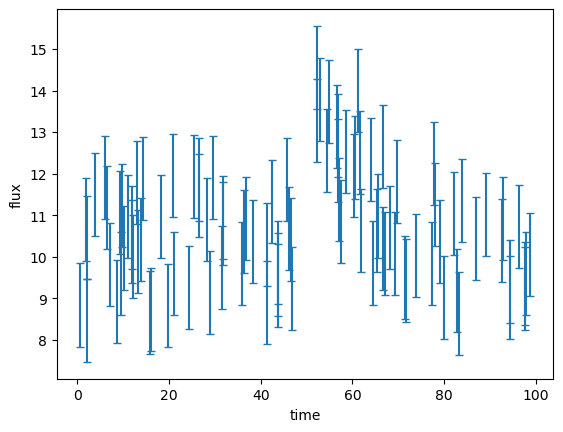

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import scipy
%matplotlib inline

#load in data
hw_data = np.load("../../../homeworks/hw_data/hw5_data_1.npy")
time = hw_data[:,0]
flux = hw_data[:,1]
uncertainties = hw_data[:,2]

plt.errorbar(time,flux, yerr=uncertainties, capsize=3, fmt="none")
plt.xlabel('time')
plt.ylabel('flux')

Part 2

In [3]:
#make burst model
def burst_model(b, A, t_0, alpha,t):
    y_arr=[] #initialize array
    for t_i in t:
        y=0
        if t_i < t_0:
            y = b
        else:
            y = b + A*np.exp(-alpha*(t_i-t_0))
        y_arr.append(y)
    return y_arr

#make likelihood function
def logL(theta, data=[time,flux,uncertainties], model=burst_model):
    """Gaussian log-likelihood of the model at theta"""
    b,A,t_0,alpha = theta
    time, flux, uncertainties = data
    y_fit = model(b,A,t_0,alpha,time)
    return sum(scipy.stats.norm.logpdf(*args)
               for args in zip(flux, y_fit, uncertainties))

Part 3

In [55]:
#use PTMCMC
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

#define prior
def Prior(theta):
    # create a uniform prior in mu and sigma
    prior_b = scipy.stats.uniform.pdf(theta[0], loc=0, scale=50)
    prior_A = scipy.stats.uniform.pdf(theta[1], loc=0, scale=50)
    prior_t_0 = scipy.stats.uniform.pdf(theta[2], loc=0, scale=100)
    prior_alpha = scipy.stats.uniform.pdf(np.log(theta[3]), loc=-5, scale=10) #log uniform for alpha
    return  prior_b* prior_A * prior_t_0 * prior_alpha

#convert to log
def logPrior(theta):
    return np.log(Prior(theta))
###############

# dimension of parameter space
ndim = 4

# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.01**2)

# intialize sampler
sampler = ptmcmc(ndim, logL, logPrior, cov, 
                 outDir='./my_ptmcmc_chain', resume=False)

# sampler for N steps
N = int(1e5)
x0 = np.array([10.0,5.0,50.0,0.1]) #initial guesses
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50)
#this step takes ~6-7 mins 

Finished 0.00 percent in 0.000430 s Acceptance rate = 0

/tmp/ipykernel_6722/2190226287.py:9: RuntimeWarning: invalid value encountered in log
  prior_alpha = scipy.stats.uniform.pdf(np.log(theta[3]), loc=-5, scale=10)


Finished 2.00 percent in 7.170298 s Acceptance rate = 0.743

/tmp/ipykernel_6722/2190226287.py:13: RuntimeWarning: divide by zero encountered in log
  return np.log(Prior(theta))


Finished 10.00 percent in 36.887500 s Acceptance rate = 0.53853Adding DE jump with weight 50
Finished 100.00 percent in 383.524604 s Acceptance rate = 0.45498
Run Complete


Part 4

Taking every n = 11 samples based on ac length.
Burning first n = 500 samples.


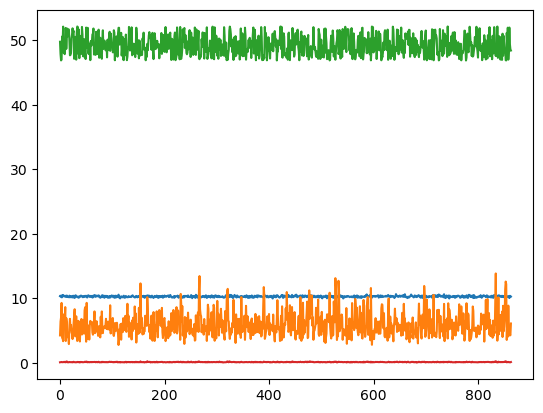

In [11]:
# Load in the chain
chain = np.loadtxt('./my_ptmcmc_chain/chain_1.txt')

import acor
thin = max([int(acor.acor(chain[:,i])[0]) for i in range(4)]) #find maximum correlation length
print('Taking every n = ' + str(thin) + ' samples based on ac length.')
print('Burning first n = ' + str(500) + ' samples.')

plt.plot(chain[500::thin,0]);
plt.plot(chain[500::thin,1]);
plt.plot(chain[500::thin,2]);
plt.plot(chain[500::thin,3]);

Part 5

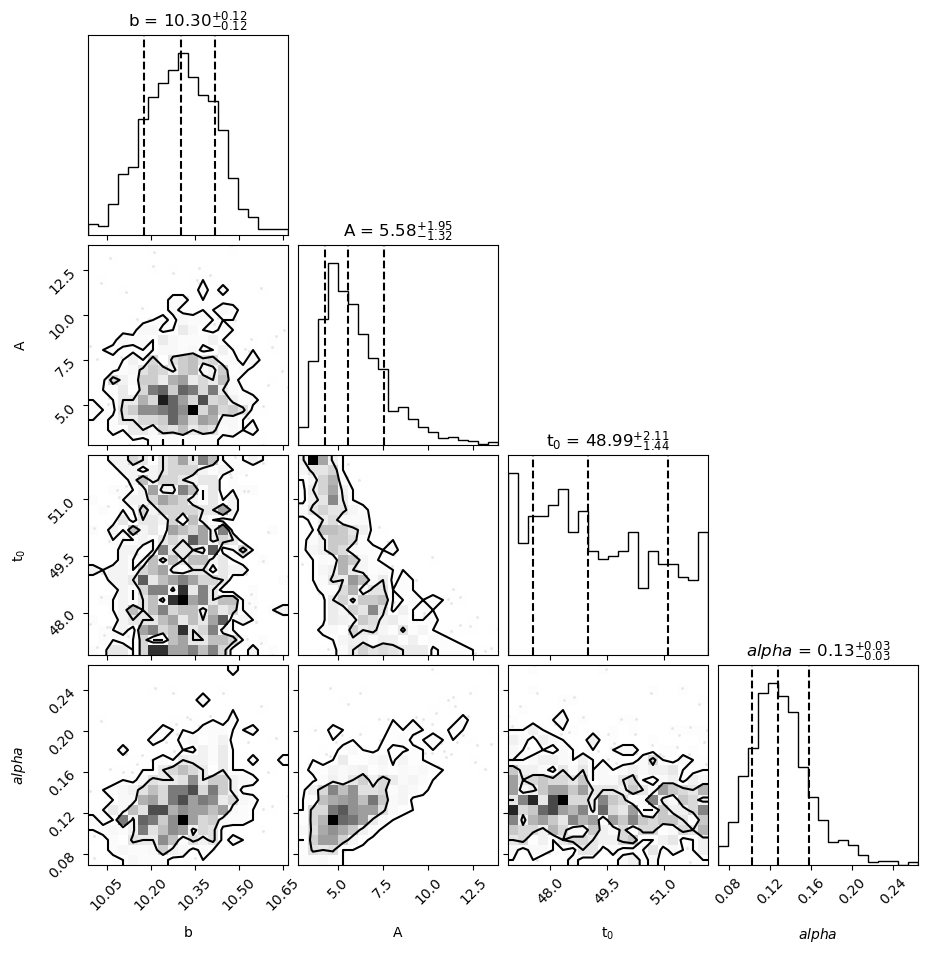

In [12]:
import corner
good_data = chain[500::thin,:4]
corner.corner(good_data,levels=[0.68, 0.95],show_titles=True, title_kwargs={"fontsize": 12}, quantiles=[0.16, 0.50, 0.84],labels=["b", "A", "t$_0$", "$alpha$"]);

Part 6

Text(0, 0.5, 'flux')

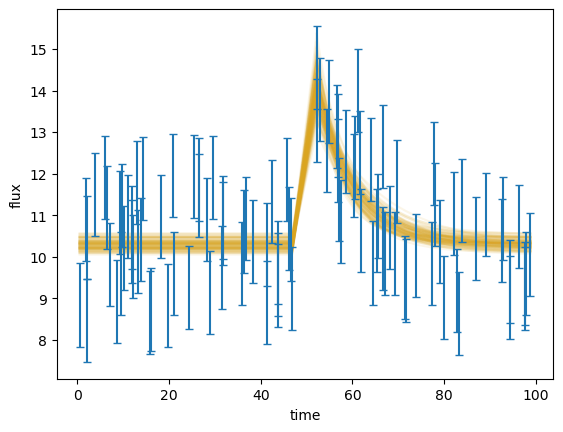

In [18]:
import random

#grab 100 random indices
samples_index = random.sample(range(len(list(good_data[:,0]))),100)

#time series for random sample
burst = []
for sample in samples_index:
    rand_samples = burst_model(good_data[sample,0],good_data[sample,1], good_data[sample,2], good_data[sample,3], time)
    plt.plot(time,rand_samples, color='goldenrod', alpha=0.1)
plt.errorbar(time,flux, yerr=uncertainties, capsize=3, fmt="none")
plt.xlabel('time')
plt.ylabel('flux')


Part 7

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-5e+01   [-52.5546..-52.5540]*| it/evals=8040/58456 eff=13.8487% N=400        0 
[ultranest] Likelihood function evaluations: 58484
[ultranest]   logZ = -68.08 +- 0.1131
[ultranest] Effective samples strategy satisfied (ESS = 2152.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.11 tail:0.01 total:0.11 required:<0.50
[ultranest] done iterating.

logZ = -68.036 +- 0.183
  single instance: logZ = -68.036 +- 0.184
  bootstrapped   : logZ = -68.084 +- 0.183
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    b                   : 9.83  │ ▁ ▁▁▁▁▁▁▁▁▂▂▃▃▄▅▆▇▇▇▇▆▆▅▄▄▃▂▁▁▁▁▁▁▁▁▁ │10.77     10.32 +- 0.12
    A                   : 1.29  │ ▁▁▁▁▁▁▂▃▄▅▇▇▇▇▆▆▄▃▂▁▂▁▁▁▁▁▁▁▁▁      ▁ │5.39      2.76 +- 0.38
    t$_0$               : 51.6

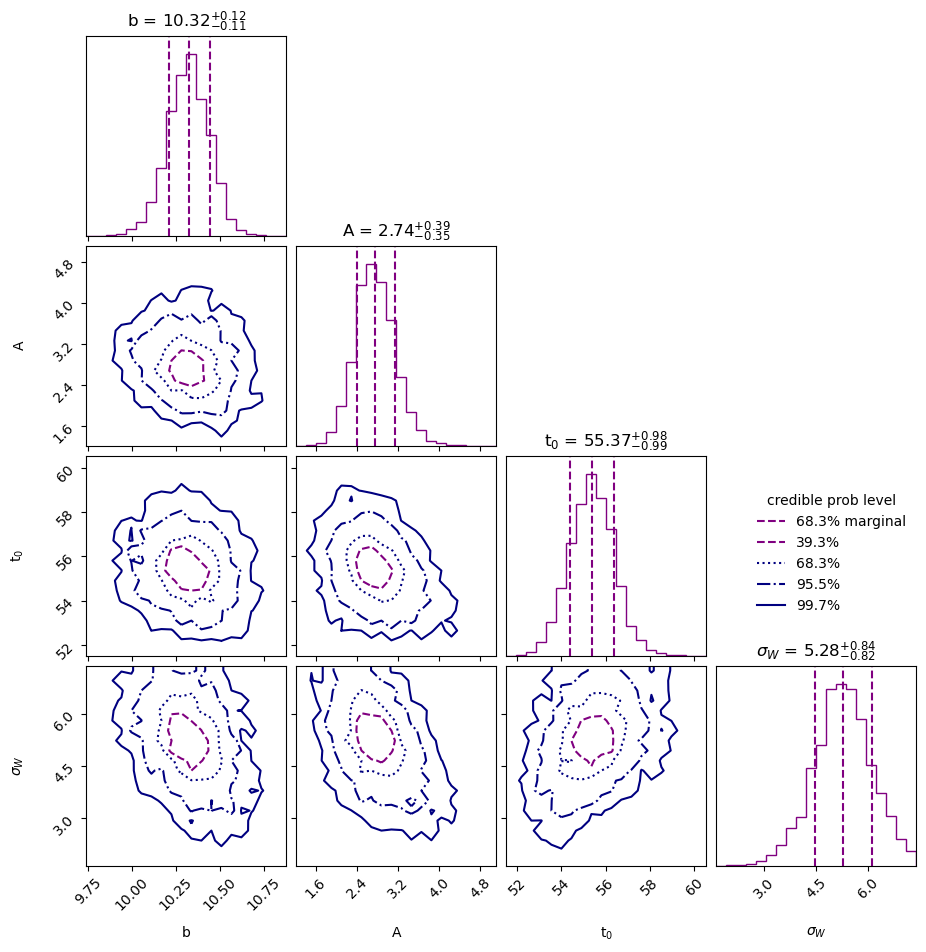

In [14]:
#make param names
param_names = ['b', 'A', 't$_0$', '$\sigma_W$']
def my_prior_transform(cube):
    params = cube.copy()

    # transform location parameter: uniform prior
    params[0] = cube[0] * (50-0)
    params[1] = cube[1] * (50-0)
    params[2] = cube[2] * (100-0)

    # transform amplitude parameter: log-uniform prior
    lo = np.exp(-2)
    hi = np.exp(2)
    params[3] = np.exp(cube[3] * (np.log(hi) - np.log(lo)) + np.log(lo))

    return params

def my_likelihood(params, data=[time, flux, uncertainties]):
    time, flux, uncertainties = data
    b,A,t_0,sigma_w = params
    # compute intensity at every x position according to the model
    y_model = b + A*np.exp(-(time - t_0)**2/(2*sigma_w**2))
    
    # compare model and data with gaussian likelihood:
    like = -0.5 * (((y_model - flux)/uncertainties)**2).sum()
    return like

#use ultranest
import ultranest

sampler = ultranest.ReactiveNestedSampler(param_names, my_likelihood, 
                                          my_prior_transform)

result = sampler.run()
sampler.print_results()

from ultranest.plot import cornerplot
cornerplot(result);


In [19]:
evidence_gauss = np.exp(result['logz'])
print('the bayesian evidence for the gaussian model is:',evidence_gauss)

the bayesian evidence for the gaussian model is: 2.832357180135764e-30


In [16]:
#repeat for burst model
def my_prior_transform_burst(cube_burst):
    params_burst = cube_burst.copy()

    # transform location parameter: uniform prior
    params_burst[0] = cube_burst[0] * (50-0)
    params_burst[1] = cube_burst[1] * (50-0)
    params_burst[2] = cube_burst[2] * (100-0)

    # transform amplitude parameter: log-uniform prior
    lo = np.exp(-5)
    hi = np.exp(5)
    params_burst[3] = np.exp(cube_burst[3] * (np.log(hi) - np.log(lo)) + np.log(lo))

    return params_burst

def my_likelihood_burst(params_burst, data=[time, flux, uncertainties]):
    time, flux, uncertainties = data
    b,A,t_0,alpha = params_burst
    y_model = burst_model(b,A,t_0,alpha,time)
    # compare model and data with gaussian likelihood:
    like = -0.5 * (((y_model - flux)/uncertainties)**2).sum()
    return like

param_names_burst = ['b','A', 't_0', 'alpha']

sampler_burst = ultranest.ReactiveNestedSampler(param_names_burst, my_likelihood_burst, 
                                          my_prior_transform_burst)

result_burst = sampler_burst.run()
sampler_burst.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-5e+01   [-48.8158..-48.8156]*| it/evals=7760/80513 eff=9.6863% N=400      0  0 
[ultranest] Likelihood function evaluations: 80580
[ultranest]   logZ = -63.6 +- 0.1334
[ultranest] Effective samples strategy satisfied (ESS = 1891.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.13 tail:0.01 total:0.13 required:<0.50
[ultranest] done iterating.

logZ = -63.610 +- 0.292
  single instance: logZ = -63.610 +- 0.183
  bootstrapped   : logZ = -63.599 +- 0.292
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    b                   : 9.76  │ ▁▁  ▁▁▁▁▁▁▁▂▂▃▄▅▅▆▇▇▇▇▆▅▅▃▃▂▂▁▁▁▁▁▁▁▁ │10.76     10.29 +- 0.12
    A                   : 1.5   │ ▁▁▃▅▇▇▇▆▄▄▃▂▁▁▁▁▁▁▁▁▁▁ ▁▁    ▁      ▁ │22.7      5.7 +- 1.6
    t_0                 : 46.6  │

the bayesian evidence for the burst model is: 2.3683841573654695e-28


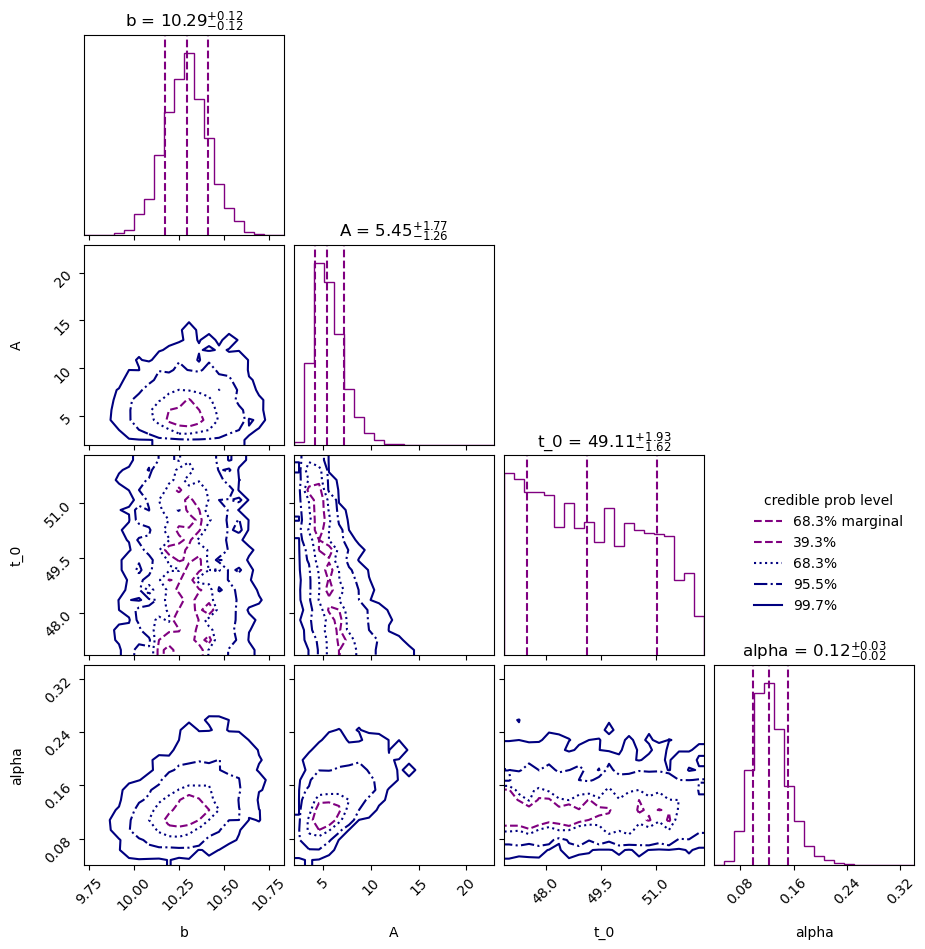

In [23]:
cornerplot(result_burst);

evidence_burst = np.exp(result_burst['logz'])
print('the bayesian evidence for the burst model is:',evidence_burst)

In [24]:
bayes_factor = evidence_burst/evidence_gauss
print('the bayes factor is:', bayes_factor)
print('the burst model better describes the data')

the bayes factor is: 83.61883783499174
the burst model better describes the data
